### HW2 
##### Anna Dodson
##### Nov 1, 2024


81
Eigenvalue for mode 1: 0.9997357913525775
Sanity check our energy is still 1: 1.0
Eigenvalue for mode 2: 2.9990032949717715
Sanity check our energy is still 1: 1.0
Eigenvalue for mode 3: 4.998472396400757
Sanity check our energy is still 1: 1.0000000000000002
Eigenvalue for mode 4: 6.997636024025269
Sanity check our energy is still 1: 1.0
Eigenvalue for mode 5: 8.996609870460816
Sanity check our energy is still 1: 1.0


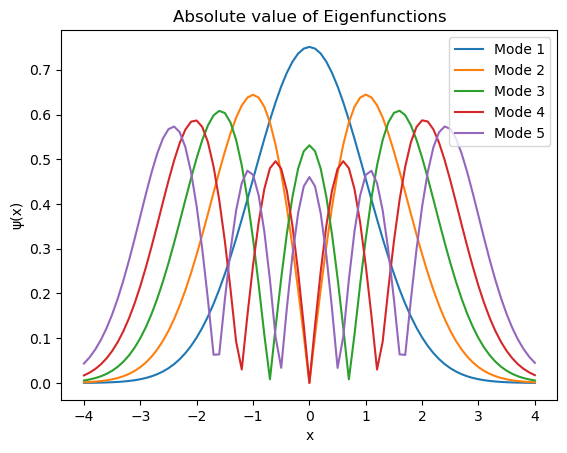

Eigenvalues: [0.99973579 2.99900329 4.9984724  6.99763602 8.99660987]


In [5]:
# HW 2 carry over for A1, A2

import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from typing import Tuple

# Initialize parameters
L = 4
dx = .1
N = int(2*L/dx) + 1 # include both endpoints
print(N)
K = 1
x = np.linspace(-L, L, N)  # Discretized domain
tol = 10e-4  # Tolerance for convergence

# Define the system of ODEs for ψ and ψ'
def shooting_system(x, y, K, beta, gamma):
    return [y[1], (K * x**2 - beta) * y[0]] # the rhs of the 1st order ODE

def find_eigenvalues_and_eigenfunctions(K, x, shooter, tol, gamma = 0, num_eigenvalues = 5, A = 1.0):
    beta_start = 1  # Initial guess for eigenvalue
    eigenvalues = []
    eigenfunctions = []

    # Get each mode
    for mode in range(1, num_eigenvalues + 1):
        beta = beta_start  # Start beta for this mode
        y0 = [A, A*np.sqrt(K*L**2 - beta)]  # Initial condition for y and its derivative
        dbeta = 0.5  # Initial step size for beta
        delta_A = .1
        x_span = (x[0], x[-1])
        for _ in range(1000):  # Loop to converge on eigenvalue
            # Solve ODE system with current beta
            sol = solve_ivp(shooter, x_span, y0, t_eval=x, args=(K, beta, gamma)).y.T # TODO change to solve_ivp

            # Check for convergence at x = L
            if abs(sol[-1, 1] + A*np.sqrt(K*L**2 - beta) * sol[-1, 0]) < tol:
                print(f"Eigenvalue for mode {mode}: {beta}")
                eigenvalues.append(beta)
                # first row is your eigenfunction
                # normalize it
                integral = np.trapz(abs(sol[:, 0])**2, x)
                if abs(integral) > 0: # don't divide by 0
                    normalized_function = sol[:, 0] / np.sqrt(integral)
                else:
                    normalized_function = sol[:, 0]  # Avoid division by zero
                integral2 = np.trapz(abs(normalized_function)**2, x)
                print("Sanity check our energy is still 1:", integral2) # should be = 1
                eigenfunctions.append(abs(normalized_function))  # Normalize
                break
            # Adjust beta based on the boundary value
            if (-1)**(mode + 1) * (sol[-1, 1] + A*np.sqrt(K*L**2 - beta) * sol[-1, 0]) > 0:
                beta += dbeta
            else:
                beta -= dbeta / 2
                dbeta /= 2
        
        # Plot absolute value of eigenfunction
        plt.plot(x, abs(normalized_function), label=f'Mode {mode}')
        beta_start = beta + 1  # Update starting beta for the next mode

    plt.legend()
    plt.xlabel('x')
    plt.ylabel('ψ(x)')
    plt.title('Absolute value of Eigenfunctions')
    plt.show()

    return np.array(eigenvalues), np.column_stack(eigenfunctions)

# Find and plot eigenvalues and eigenfunctions
eigenvalues, abs_eigenfunctions = find_eigenvalues_and_eigenfunctions(K, x, shooting_system, tol)

# Output the eigenvalues and eigenfunctions
print("Eigenvalues:", eigenvalues)
A1 = abs_eigenfunctions
A2 = eigenvalues

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

# FD method for Dxx with second order accurate BC
def compute_dxx(L, dx=.1):
    dx = .1

    N = int(2*L/dx) - 1 # include neither endpoint

    print(N)
    # Construct the second derivative matrix (central finite difference)
    # need to add V(x) = K * x^2 to the linear operator
    Dxx = (-2 * np.eye(N) + np.eye(N, k=1) + np.eye(N, k=-1))/(dx**2) # This only accounts for the middle of the matrix
    Dxx[0, 0] = (-2+(4/3))/(dx**2)
    Dxx[0, 1] = (1-1/3)/(dx**2)
    Dxx[-1, -2] = (1-1/3)/(dx**2)
    Dxx[-1, -1] = (-2+(4/3))/(dx**2)

    return Dxx

79


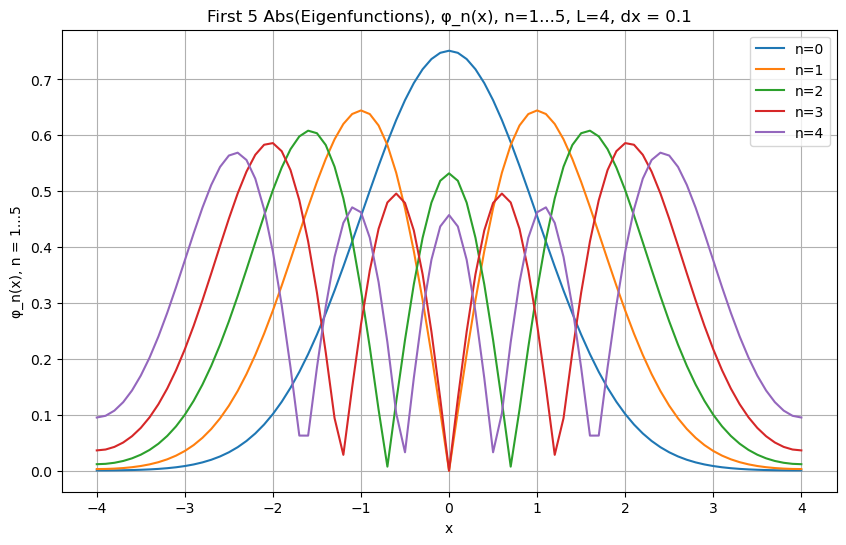

[0.99937352+0.j 2.996839  +0.j 4.99140656+0.j 6.98038865+0.j
 8.95060003+0.j]


In [7]:
# Part b) Directly solving d2φn −[Kx2 −εn]φn = 0 

L = 4  # Domain should be [-L, L]
K = 1
x = np.linspace(-L+dx, L-dx, N-2)  # Discretized x domain
Dxx = compute_dxx(L)

V = np.diag(K * x**2)
Linop = -Dxx + V

# Solve the eigenvalue problem L*lambda = eps*lambda
# eigh is generally used for Hermitian matrices, 
# returns sorted eigenvalues/eigenvectors
eigenvalues, eigenfunctions = scipy.sparse.linalg.eigs(Linop, k=5, which='SM')

# Add back the phi0 and phiN
eigenfn_0 = 4/3*eigenfunctions[0] - 1/3*eigenfunctions[1]
eigenfn_n = 4/3*eigenfunctions[-1] - 1/3*eigenfunctions[-2]

eigenfunctions = np.vstack([eigenfn_0, eigenfunctions, eigenfn_n])
x = np.linspace(-L, L, N)  # Discretized x domain

# Normalize the eigenfunctions as required by the problem
eigenfunctions /= np.sqrt(np.trapz(np.abs(eigenfunctions)**2, x, axis=0))

# Extract our solutions: first 5 eigenvalues and eigenfunctions
# Note it's already sorted due to using eigh
A3 = abs(eigenfunctions[:, :5]) # normalized eigenfunctions
A4 = eigenvalues[:5] 


# Plot the first 5 eigenfunctions
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(x, A3[:, i], label=f'n={i}')
plt.title(f'First 5 Abs(Eigenfunctions), φ_n(x), n=1...5, L={L}, dx = {dx}')
plt.xlabel('x')
plt.ylabel('φ_n(x), n = 1...5')
plt.legend()
plt.grid(True)
plt.show()

print(A4)

RHS is 0.00010735550785137673
eigenfunction_area is: 1.9731575599092295e-09 and A is 1e-06
RHS is -0.01739638895575308
eigenfunction_area is: 0.008288746714246287 and A is 0.010001
RHS is -0.0344129782367118
eigenfunction_area is: 0.0331827388260074 and A is 0.020000999999999998
RHS is -0.05241786726395025
eigenfunction_area is: 0.07445928625535837 and A is 0.030001
RHS is -0.06937357291680306
eigenfunction_area is: 0.13238298927187775 and A is 0.040001
RHS is -0.0869054509072603
eigenfunction_area is: 0.2065566511611782 and A is 0.050001000000000004
RHS is -0.10382370675919937
eigenfunction_area is: 0.2972108657226623 and A is 0.060001000000000006
RHS is -0.12127442450279559
eigenfunction_area is: 0.40382750659242483 and A is 0.07000100000000001
RHS is -0.138427384565909
eigenfunction_area is: 0.5265684086095037 and A is 0.080001
RHS is -0.15580688241000565
eigenfunction_area is: 0.6650200392196003 and A is 0.090001
RHS is -0.17280328920127194
eigenfunction_area is: 0.8193237355260492

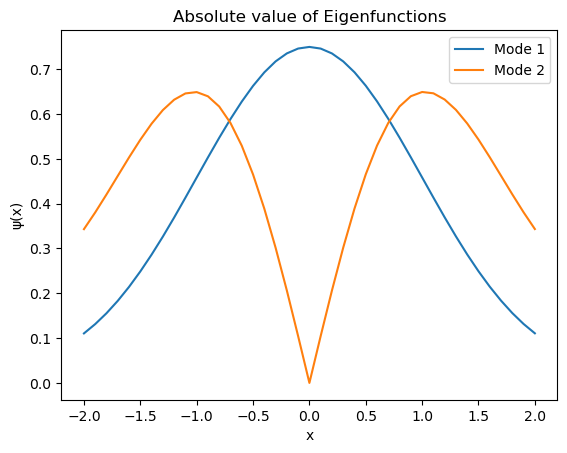

Eigenvalues: [1.01289062 2.92148438]


In [8]:
# Part c- Nonlinear v component
# Now we model d2φn −[γ|φn|2 +Kx2 −εn]φn =0.

# A5 and A6
gamma = .05

# Initialize parameters
L = 2
dx = .1
N = int(2*L/dx) + 1 # include both endpoints
K = 1
y0 = [0, 1]  # Initial guesses for y and its derivative
x = np.linspace(-L, L, N)  # Discretized domain
tol = 10e-4 # Tolerance for convergence

# Define the system of ODEs for ψ and ψ', nonlinearly now
def nonlinear_shooting_system(x, y, K, beta, gamma):
    return [y[1], ((gamma*(np.abs(y[0])**2)) + K * x**2 - beta) * y[0]] # the rhs of the 1st order ODE

def find_eigenvalues_and_eigenfunctions_nonlinear(K, x, shooter, tol, gamma = 0, num_eigenvalues = 5, A_start = .001):
    beta_start = .1  # Initial guess for eigenvalue
    eigenvalues = []
    eigenfunctions = []
    x_span = (x[0], x[-1])
    # Get each mode

    A = A_start

    for mode in range(1, num_eigenvalues + 1):
        delta_A = 0.01
        sol = None
        for _ in range(1000):  # Loop to converge on A
            beta = beta_start  # Start beta for this mode
            dbeta = 0.2  # Initial step size for beta

            for _ in range(1000):  # Loop to converge on eigenvalue
                # Solve ODE system with current beta
                y0 = [A, A*np.sqrt(K*L**2 - beta)]  # Initial condition for y and its derivative

                sol = solve_ivp(shooter, x_span, y0=y0, t_eval=x, args=(K, beta, gamma)).y.T
                
                # Check for convergence at x = L, the right endpoint
                if abs(sol[-1, 1] + np.sqrt(K*L**2 - beta) * sol[-1, 0]) < tol:
                    print(f"RHS is {sol[-1, 1]}")
                    break
                    
                # Adjust beta based on the boundary value
                if (-1)**(mode + 1) * (sol[-1, 1] + np.sqrt(K*L**2 - beta) * sol[-1, 0]) > 0:
                    beta += dbeta
                else:
                    beta -= dbeta / 2
                    dbeta /= 2

            # Adjust A based on the area of the eigenfunction
            eigenfunction_area = np.trapz(abs(sol[:, 0])**2, x)
            print(f"eigenfunction_area is: {eigenfunction_area} and A is {A}")
            if abs(eigenfunction_area - 1) < tol:
                print(f"Eigenvalue for mode {mode}: {beta}")     
                eigenvalues.append(beta)
                eigenfunctions.append(abs(sol[:, 0]))  # Normalized since we have tuned A.
                break

            if eigenfunction_area  - 1 < 0: #eigenfunction area is too small
                A += delta_A
            else: # eigenfunction area is too big, so move A up a bit to adjust
                A -= delta_A/2
                delta_A /= 2

        # Plot absolute value of eigenfunction
        plt.plot(x, abs(sol[:, 0]), label=f'Mode {mode}')
        beta_start = beta + 1  # Update starting beta for the next mode
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('ψ(x)')
    plt.title('Absolute value of Eigenfunctions')
    plt.show()

    return np.array(eigenvalues), np.column_stack(eigenfunctions)

# Find and plot eigenvalues and eigenfunctions
A = 1e-6

eigenvalues, abs_eigenfunctions = find_eigenvalues_and_eigenfunctions_nonlinear(K=K, x=x, shooter=nonlinear_shooting_system, tol=tol, gamma=gamma, num_eigenvalues=2, A_start=A)

# Output the eigenvalues and eigenfunctions
print("Eigenvalues:", eigenvalues)
A5 = abs_eigenfunctions
A6 = eigenvalues


RHS is 0.00010735550784001783
eigenfunction_area is: 1.9731575597681555e-09 and A is 1e-06
RHS is -0.0175132311296664
eigenfunction_area is: 0.008283454385050406 and A is 0.010001
RHS is -0.03478671586903851
eigenfunction_area is: 0.03316847966827555 and A is 0.020000999999999998
RHS is -0.05220148289834706
eigenfunction_area is: 0.07466548701724689 and A is 0.030001
RHS is -0.06954878242618003
eigenfunction_area is: 0.1328619257217809 and A is 0.040001
RHS is -0.08676432187999387
eigenfunction_area is: 0.2078776177195369 and A is 0.050001000000000004
RHS is -0.10378834260705568
eigenfunction_area is: 0.299872744578942 and A is 0.060001000000000006
RHS is -0.12153963280861961
eigenfunction_area is: 0.4086154378154261 and A is 0.07000100000000001
RHS is -0.13926890550316126
eigenfunction_area is: 0.5345113702699782 and A is 0.080001
RHS is -0.15631302396143779
eigenfunction_area is: 0.6781371998103782 and A is 0.090001
RHS is -0.17381233593257928
eigenfunction_area is: 0.839121536207134

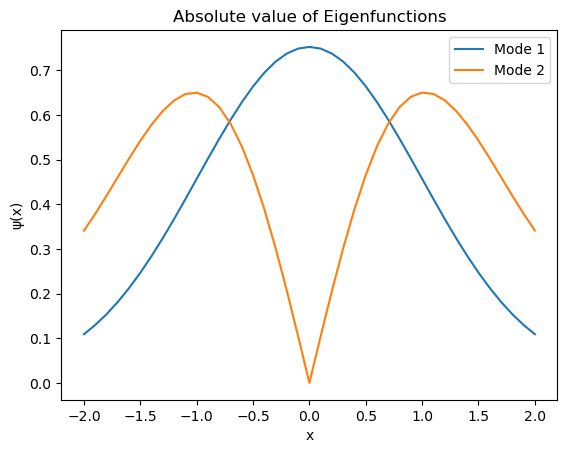

[0.97402344 2.89316406]


In [9]:
gamma = -.05
eigenvalues, abs_eigenfunctions = find_eigenvalues_and_eigenfunctions_nonlinear(K, x, nonlinear_shooting_system, tol, gamma=gamma, num_eigenvalues=2, A_start=A)
A7 = abs_eigenfunctions
A8 = eigenvalues
print(A8)

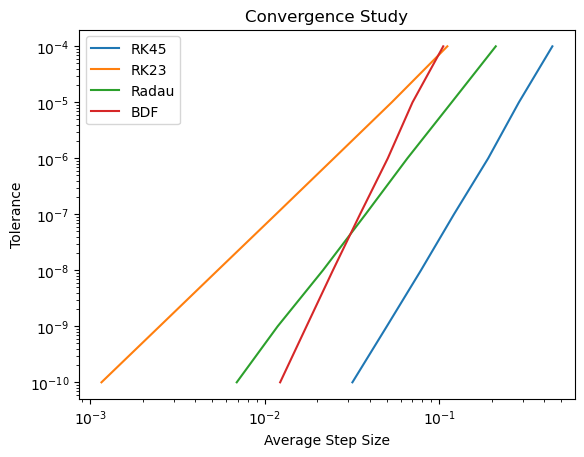


[5.24466756 3.01909953 4.03819927 6.45751261]
Examining the log-log slopes, we can obtain estimates of the error degree. 
First, note that the error in RK45 is indeed 10^-5 and the error in RK23 is 10^-3.
Then extrapolating from there, it would appear that the error in Radau is 10^-4 and the error in BDF is 10^-6.


In [10]:
# Part d
eps = 1
gamma = 0
L = 2
K = 1

# Convergence study function
def convergence_study(x, L, K, beta, gamma, methods=['RK45', 'RK23', 'Radau', 'BDF']):
    tolerances = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
    avg_step_sizes = {method: [] for method in methods}
    slopes = []
    y0 = [1, np.sqrt(K*L**2 - 1)]  # Initial conditions for ψ and ψ'
    x_span = (x[0], x[-1])

    for method in methods:
        for tol in tolerances:
            # Solve the ODE for each tolerance level
            options = {"rtol": tol, "atol": tol}
            sol = solve_ivp(shooting_system, x_span, y0, method=method, args=(K, beta, gamma), **options)
            # Calculate the average step size
            step_sizes = np.diff(sol.t)
            avg_step_size = np.mean(step_sizes)
            avg_step_sizes[method].append(avg_step_size)
        # Plotting the log-log plot for the method
        plt.loglog(avg_step_sizes[method], tolerances, label=method)
        
        # Fit to find the slope
        slope, _ = np.polyfit(np.log(avg_step_sizes[method]), np.log(tolerances), 1)
        slopes.append(slope)

    plt.xlabel('Average Step Size')
    plt.ylabel('Tolerance')
    plt.legend()
    plt.title('Convergence Study')
    plt.show()

    # Return slopes for RK45, RK23, Radau, and BDF in a vector
    return np.array(slopes)


# Run the convergence study
slopes = convergence_study(x, L, K, beta=eps, gamma=gamma)
print(slopes)
print(f"Examining the log-log slopes, we can obtain estimates of the error degree. \n"
      "First, note that the error in RK45 is indeed 10^-5 and the error in RK23 is 10^-3."
       "\nThen extrapolating from there, it would appear that the error in Radau is 10^-4 and the error in BDF is 10^-6.")

A9 = slopes

(81,)
(81,)


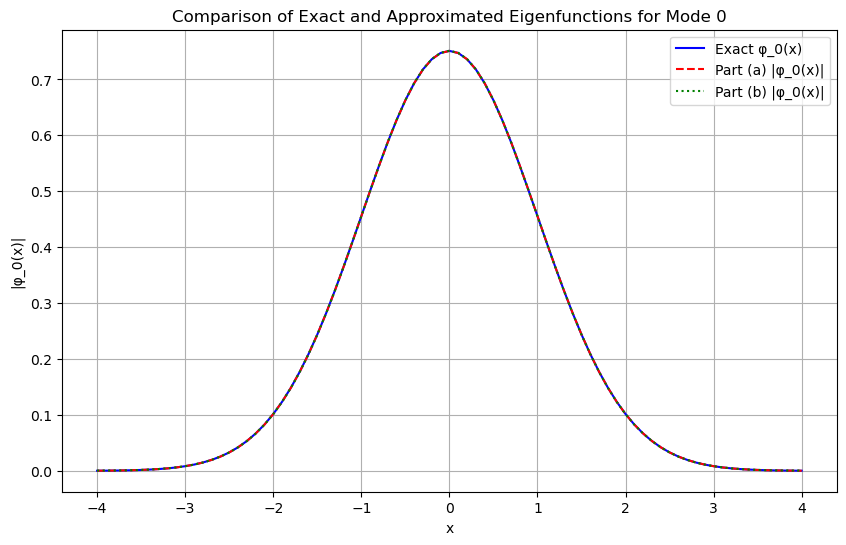

(81,)
(81,)
(81,)
(81,)


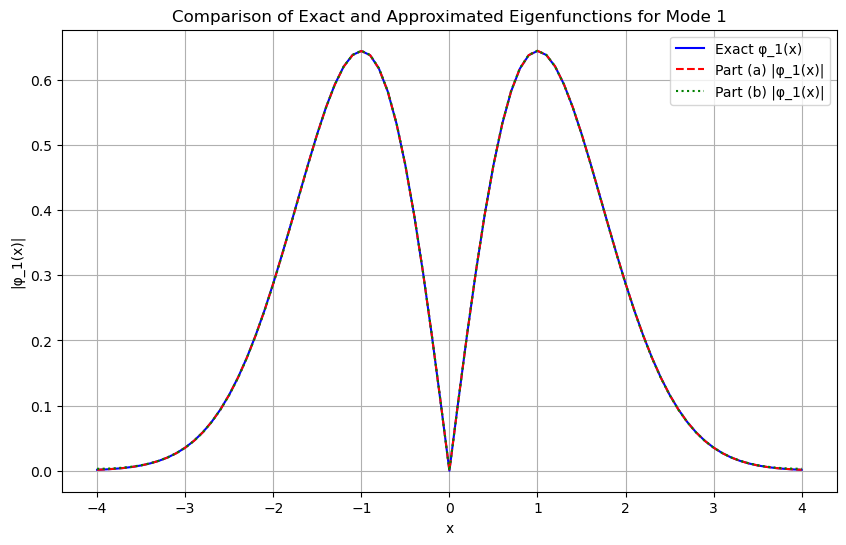

(81,)
(81,)
(81,)
(81,)


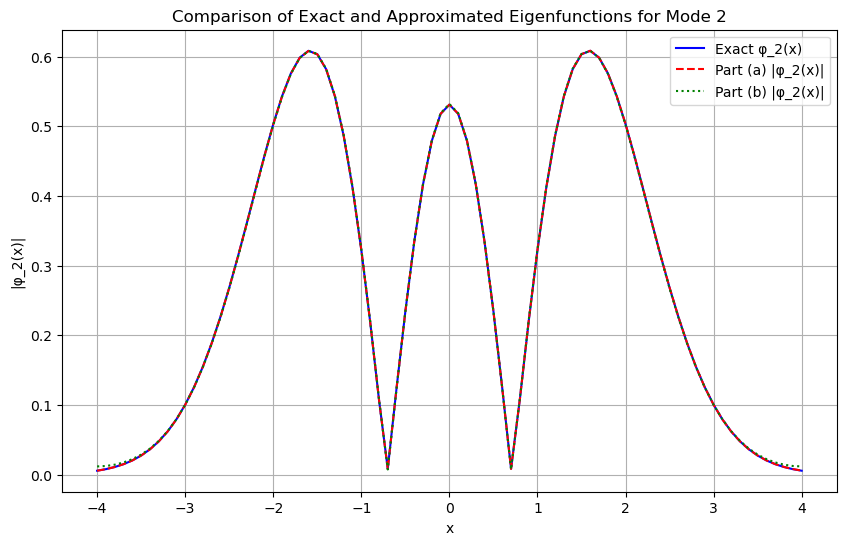

(81,)
(81,)
(81,)
(81,)


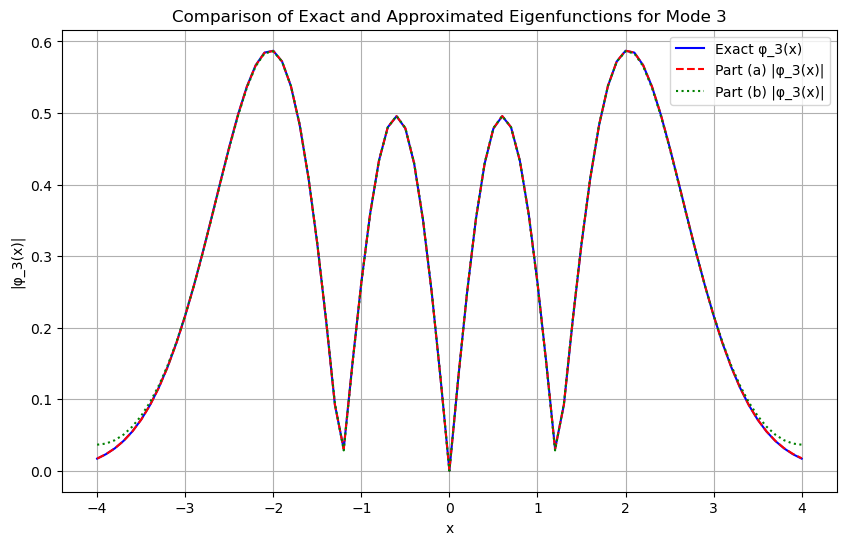

(81,)
(81,)
(81,)
(81,)


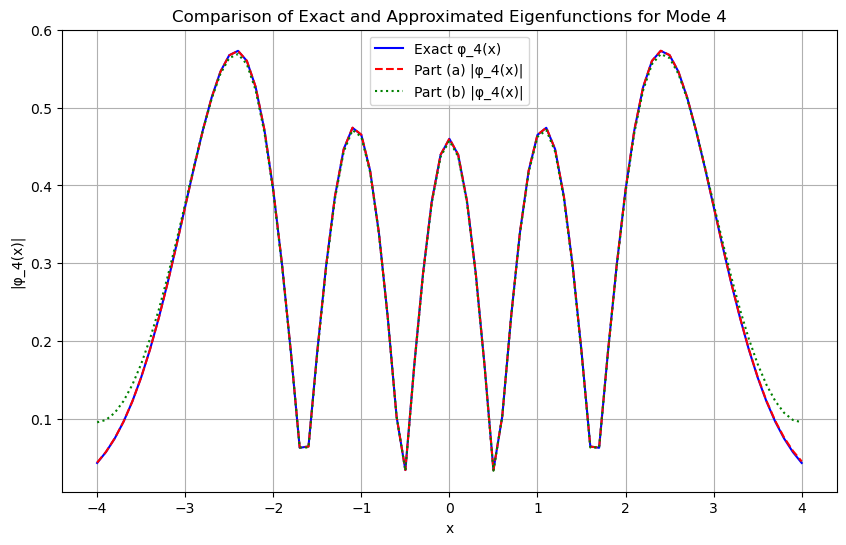

(81,)
(81,)
[4.57693894867948e-08, 1.724240686881418e-07, 2.4894015902576383e-07, 4.2845652012492464e-07, 1.3264815464851871e-06]
[0.02642086474224925, 0.033223500940948725, 0.03055207198485732, 0.0337710853533021, 0.03766810599093636]
[2.3390857876003103e-07, 2.3972032037502992e-06, 1.8127599622584117e-05, 0.00015304807178694347, 0.0012423860026055107]
[0.0626477036923534, 0.1053667337229817, 0.17186880398503135, 0.2801621353890203, 0.5488885888100172]


In [11]:
# part e)

# Compare the exact Gauss-Hermite polynomial solutions for this problem with a) and b) 
# Compare your solutions in both (a) and (b) with the exact Gauss-Hermite polynomial
# solutions for this problem (See wikipedia.com, for instance). Compute the error between your numerical solu-
# tion and the exact solution for the values of the eigenfunctions and eigenvalues computed above. Specifically,
# calculate the following quantity for each eigenfunction ∥ |φnumerical|−|φexact| ∥ where ∥f(x)∥ = RL f(x)2dx. n n −L
# For the eigenvalues, simply calculate the relative percent error 100 × (|εnumerical − εexact|/εexact). The error nnn
# vectors associated with the eigenfunctions and eigenvalues should be 5x1 vectors.

from scipy.integrate import quad
from scipy.special import hermite

num_eigenvalues = 5

L = 4
dx = .1
N = int(2*L/dx) + 1 # include both endpoints
K = 1
x = np.linspace(-L, L, N)  # Discretized domain
tol = 10e-4  # Tolerance for convergence

# Hermite polynomials can be generated using 
# Quantum harmonic oscillator 

def factorial(n):
    result = 1
    for i in range(1, n + 1):
        result *= i
    return result

# H_n(x) = (-1)^n * exp(x^2) * (d^n/dx^n) [exp(-x^2)];
def phi_exact(x, n):
    H_n = hermite(n)  # Hermite polynomial of degree n
    norm_factor = (2**n * factorial(n) * np.sqrt(np.pi))**(-0.5)
    return norm_factor * np.exp(-x**2 / 2) * H_n(x)

# Define numerical norm function
def norm_difference(phi_numerical_func, phi_exact_func, x):
    integrand = (phi_numerical_func - phi_exact_func)**2
    print(integrand.shape)
    error = np.trapz(integrand, x)
    return error

# Define eigenvalue error calculation
def eigenvalue_relative_error(E_numerical, E_exact):
    return 100 * abs(E_numerical - E_exact) / E_exact

eigenfunction_errors_a = []
eigenvalue_errors_a = []
eigenfunction_errors_b = []
eigenvalue_errors_b = []

for mode in range(0, num_eigenvalues):
    phi_exact_for_mode_abs = abs(phi_exact(x, mode))
    e_exact_for_mode = (mode*2) + 1
    part_a_eigenfunction_abs = A1[:, mode]
    part_a_e = A2[mode]
    print(part_a_eigenfunction_abs.shape)
    part_b_eigenfunction_abs = A3[:, mode]
    part_b_e = A4[mode]
    print(part_b_eigenfunction_abs.shape)

    # Plot the exact eigenfunction and the approximations for part (a) and (b)
    plt.figure(figsize=(10, 6))
    plt.plot(x, np.abs(phi_exact_for_mode_abs), label=f"Exact φ_{mode}(x)", color="blue")
    plt.plot(x, part_a_eigenfunction_abs, label=f"Part (a) |φ_{mode}(x)|", color="red", linestyle="--")
    plt.plot(x, part_b_eigenfunction_abs, label=f"Part (b) |φ_{mode}(x)|", color="green", linestyle=":")
    
    # Add labels, title, and legend for clarity
    plt.xlabel("x")
    plt.ylabel(f"|φ_{mode}(x)|")
    plt.title(f"Comparison of Exact and Approximated Eigenfunctions for Mode {mode}")
    plt.legend()
    plt.grid()
    plt.show()

    eigenfunction_error_a = norm_difference(part_a_eigenfunction_abs, phi_exact_for_mode_abs, x)
    eigenfunction_errors_a.append(eigenfunction_error_a)

    eigenvalue_error_a = eigenvalue_relative_error(part_a_e, e_exact_for_mode)
    eigenvalue_errors_a.append(eigenvalue_error_a)

    eigenfunction_error_b = norm_difference(part_b_eigenfunction_abs, phi_exact_for_mode_abs, x)
    eigenfunction_errors_b.append(eigenfunction_error_b)

    eigenvalue_error_b = eigenvalue_relative_error(part_b_e, e_exact_for_mode)
    eigenvalue_errors_b.append(eigenvalue_error_b)

A10 = eigenfunction_errors_a
A11 = eigenvalue_errors_a
A12 = eigenfunction_errors_b
A13 = eigenvalue_errors_b

print(A10)
print(A11)
print(A12)
print(A13)

